In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import os
from os.path import join, exists, expanduser, basename
from genericpath import isdir
from glob import glob
import numpy as np
from PIL import Image
from collections import defaultdict

from lib.r2d2.extract import extract_keypoints_modified
from relfm.utils.paths import REPO_PATH
from relfm.utils.log import print_update, tqdm_iterator
from relfm.utils.visualize import show_images_with_keypoints
from relfm.utils.matching import evaluate_matching_with_rotation, analyze_result
from relfm.inference.r2d2_on_hpatches import configure_save_dir
from relfm.utils.geometry import apply_homography_to_keypoints, append_rotation_to_homography

In [3]:
data_dir = join(REPO_PATH, "data/hpatches-sequences-release/")
model_ckpt_path = join(REPO_PATH, "checkpoints/r2d2_WASF_N16.pt")
output_dir = join(expanduser("~"), "outputs/rotation-equivariant-lfm")

In [4]:
sequence = sorted(glob(join(data_dir, "v_home*")))[0]

In [5]:
sequence

'/home/lcur1325/projects/rotation-equivariant-lfm/data/hpatches-sequences-release/v_home'

In [6]:
# load source image
img1_path = join(sequence, "1.ppm")
img1 = Image.open(img1_path)

# load all target images
img2_indices = [2, 3, 4, 5, 6]
img2s = [Image.open(join(sequence, f"{i}.ppm")) for i in img2_indices]

# load all homographies
Hs = [np.loadtxt(join(sequence, f"H_1_{i}")) for i in img2_indices]

In [7]:
save_dir = configure_save_dir(output_dir, model_ckpt_path, dataset_name="hpatches")

In [11]:
# check for a specific rotation
rotation = 30

# load outputs for all of the images
sequence_name = basename(sequence)
source_path = join(save_dir, sequence_name, f"1.npy")
target_paths = glob(join(save_dir, sequence_name, f"*_rotation_{rotation}.npy"))

In [12]:
source_path

'/home/lcur1325/outputs/rotation-equivariant-lfm/hpatches/r2d2_WASF_N16/v_home/1.npy'

In [13]:
target_paths

['/home/lcur1325/outputs/rotation-equivariant-lfm/hpatches/r2d2_WASF_N16/v_home/2_rotation_30.npy',
 '/home/lcur1325/outputs/rotation-equivariant-lfm/hpatches/r2d2_WASF_N16/v_home/3_rotation_30.npy',
 '/home/lcur1325/outputs/rotation-equivariant-lfm/hpatches/r2d2_WASF_N16/v_home/4_rotation_30.npy',
 '/home/lcur1325/outputs/rotation-equivariant-lfm/hpatches/r2d2_WASF_N16/v_home/5_rotation_30.npy',
 '/home/lcur1325/outputs/rotation-equivariant-lfm/hpatches/r2d2_WASF_N16/v_home/6_rotation_30.npy']

In [15]:
img1_output = np.load(source_path, allow_pickle=True).item()
img2_outputs = [np.load(x, allow_pickle=True).item() for x in target_paths]

In [16]:
img1_output.keys()

dict_keys(['keypoints', 'descriptors', 'scores', 'imsize'])

In [17]:
img2_outputs[0].keys()

dict_keys(['keypoints', 'descriptors', 'scores', 'imsize', 'rotation', 'H'])

In [19]:
kp1 = img1_output["keypoints"]
kp1_on_all_images = [kp1]

for j in range(len(img2_outputs)):
    img2_output = img2_outputs[j]
    H = img2_output["H"]
    
    kp1_on_all_images.append(apply_homography_to_keypoints(kp1, H))

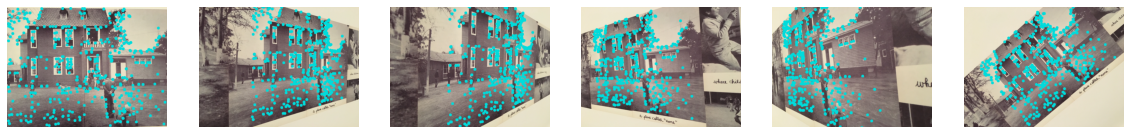

In [24]:
show_images_with_keypoints(
    [img1, *img2s], kp1_on_all_images, figsize=(20, 6), radius=10,
)

In [40]:
kp1 = img1_output["keypoints"]
kps = [kp1]
images = [img1]

for j in range(len(img2_outputs)):
    img2 = img2s[j]
    img2_rotated = img2.rotate(rotation)
    images.append(img2_rotated)

    img2_output = img2_outputs[j]
    H = img2_output["H"]
    width, height = img2.size
    H_rotated = append_rotation_to_homography(H, rotation, width, height)
    
    kps.append(apply_homography_to_keypoints(kp1, H_rotated))

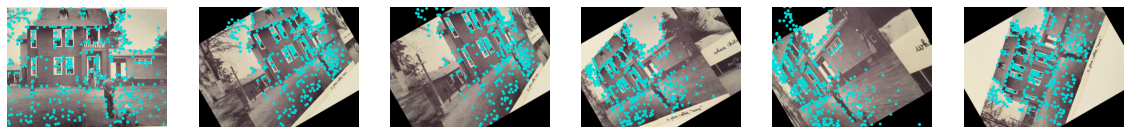

In [41]:
show_images_with_keypoints(
    images, kps, figsize=(20, 6), radius=10,
)